## Homework with Weights & Biases

The goal of this homework is to get familiar with Weights & Biases for experiment tracking, model management, hyperparameter optimization, and many more.

### Import Libraries

In [1]:
!pip install pandas matplotlib scikit-learn pyarrow wandb
!pip install mlflow jupyter seaborn hyperopt xgboost fastparquet boto3 pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


What's the version that you have?

In [1]:
import wandb
print(wandb.__version__)

0.15.4


# Q2. Download and preprocess the data

We'll use the Green Taxi Trip Records dataset to predict the amount of tips for each trip.

In [2]:
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
!wget -P ~/data https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet

--2023-06-07 18:27:32--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.84.160.116, 52.84.160.213, 52.84.160.73, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.84.160.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254291 (1.2M) [binary/octet-stream]
Saving to: ‘/root/data/green_tripdata_2022-01.parquet.1’

green_tripdata_2022 100%[===================>]   1.20M  --.-KB/s    in 0.04s   

2023-06-07 18:27:33 (34.1 MB/s) - ‘/root/data/green_tripdata_2022-01.parquet.1’ saved [1254291/1254291]

--2023-06-07 18:27:33--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.84.160.116, 52.84.160.213, 52.84.160.73, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.84.160.116|:443... con

In [3]:
!ls ~/data

green_tripdata_2022-01.parquet	  green_tripdata_2022-02.parquet.1
green_tripdata_2022-01.parquet.1  green_tripdata_2022-03.parquet
green_tripdata_2022-02.parquet	  green_tripdata_2022-03.parquet.1


Use the script preprocess_data.py located in the folder homework-wandb to preprocess the data.

The script will:

  - initialize a Weights & Biases run.
  - load the data from the folder <TAXI_DATA_FOLDER> (the folder where you have downloaded the data),
  - fit a DictVectorizer on the training set (January 2022 data),
  - save the preprocessed datasets and the DictVectorizer to your Weights & Biases dashboard as an artifact of type preprocessed_dataset.

In [4]:
import os 

WANDB_PROJECT_NAME="homework-wandb"
WANDB_USERNAME="masiff346"
TAXI_DATA_FOLDER="~/data"
DEST_PATH="output"

#!WANDB_KEY = os.environ.get('8d78fa935f9b249ff4f4de20b5d329f3f556ac40')
#%env WANDB_API_KEY=$WANDB_KEY

In [5]:
!WANDB_API_KEY=$8d78fa935f9b249ff4f4de20b5d329f3f556ac40

In [8]:
%mkdir output

mkdir: cannot create directory ‘output’: File exists


In [6]:
import wandb

wandb.login()

wandb: Currently logged in as: masiff346. Use `wandb login --relogin` to force relogin


True

In [7]:
!python preprocess_data.py \
  --wandb_project $WANDB_PROJECT_NAME \
  --wandb_entity $WANDB_USERNAME \
  --raw_data_path $TAXI_DATA_FOLDER \
  --dest_path $DEST_PATH

wandb: Currently logged in as: masiff346. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /content/wandb/run-20230607_182808-rpmeerfg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-fire-1
wandb: ⭐️ View project at https://wandb.ai/masiff346/homework-wandb
wandb: 🚀 View run at https://wandb.ai/masiff346/homework-wandb/runs/rpmeerfg
wandb: Adding directory to artifact (./output)... Done. 0.0s


In [9]:
!python preprocess_data.py --raw_data_path ~/data --dest_path ./output

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
Problem at: /content/preprocess_data.py 56 run_data_prep
Traceback (most recent call last):
  File "/content/preprocess_data.py", line 96, in <module>
    run_data_prep()
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 760, in invoke
    return __callback(*args, **kwargs)
  File "/content/preprocess_data.py", line 56, in run_data_prep
    wandb.init(project=wandb_project, entity=wandb_entity, job_type="preprocess")
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1171, in init
    raise e
  File

In [8]:
import os

file_name = "./output/dv.pkl"
file_stats = os.stat(file_name)

print(f"File size is {file_stats.st_size} bytes, {file_stats.st_size / 1024:.1f} kB, {file_stats.st_size / (1024 * 1024):.3f} MB.")

File size is 153660 bytes, 150.1 kB, 0.147 MB.


# Q3. Train a model with Weights & Biases logging

We will train a `RandomForestRegressor` (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder `homework-wandb`. 

The script will:

* initialize a Weights & Biases run.
* load the preprocessed datasets by fetching them from the Weights & Biases artifact previously created,
* train the model on the training set,
* calculate the MSE score on the validation set and log it to Weights & Biases,
* save the trained model and log it to Weights & Biases as a model artifact.

Your task is to modify the script to enable to add Weights & Biases logging, execute the script and then check the Weights & Biases run UI to check that the experiment run was properly tracked.


In [9]:
!python train.py \
    --wandb_project $WANDB_PROJECT_NAME \
    --wandb_entity $WANDB_USERNAME \
    --data_artifact "$WANDB_USERNAME/$WANDB_PROJECT_NAME/NYC-Taxi:v0"

wandb: Currently logged in as: masiff346. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /content/wandb/run-20230607_182841-joprtkhr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dark-dragon-2
wandb: ⭐️ View project at https://wandb.ai/masiff346/homework-wandb
wandb: 🚀 View run at https://wandb.ai/masiff346/homework-wandb/runs/joprtkhr
wandb:   4 of 4 files downloaded.  
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: MSE ▁
wandb: 
wandb: Run summary:
wandb: MSE 2.45398
wandb: 
wandb: 🚀 View run dark-dragon-2 at: https://wandb.ai/masiff346/homework-wandb/runs/joprtkhr
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230607_182841-joprtkhr/logs


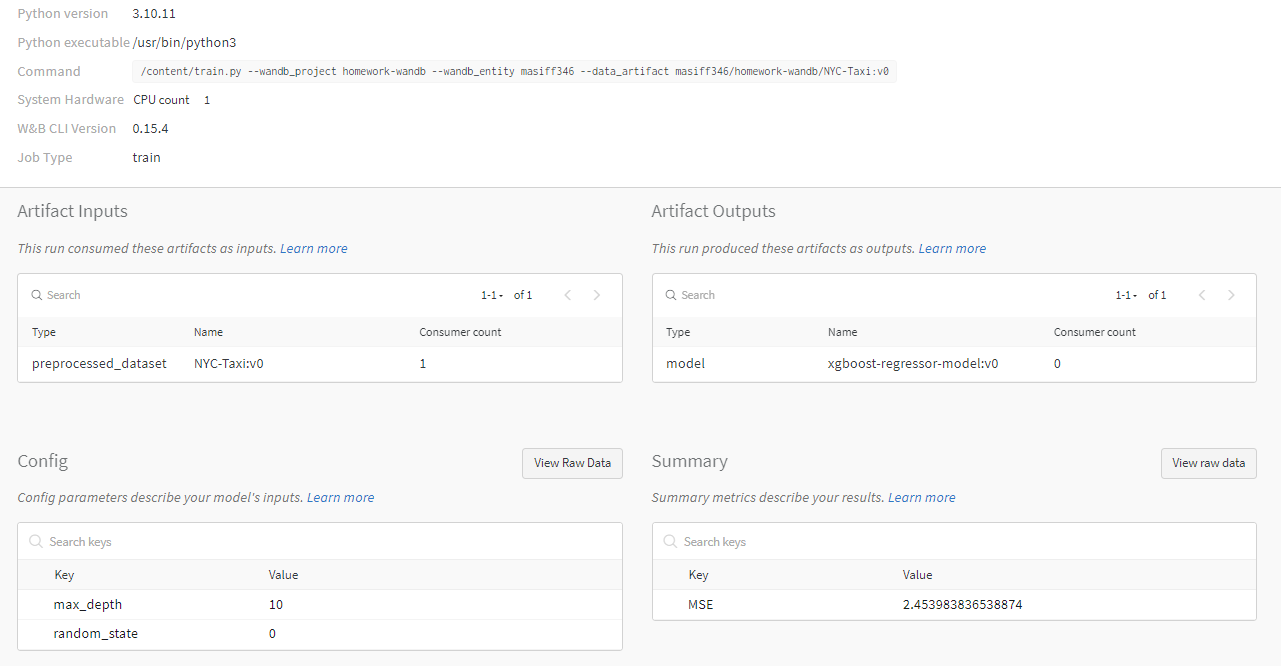

# Q4. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the `RandomForestRegressor` using [Weights & Biases Sweeps](https://docs.wandb.ai/guides/sweeps). We have prepared the script `sweep.py` for this exercise in the `homework-wandb` directory.

Your task is to modify `sweep.py` to pass the parameters `n_estimators`, `min_samples_split` and `min_samples_leaf` from `config` to `RandomForestRegressor` inside the `run_train()` function. Then we will run the sweep to figure out not only the best best of hyperparameters for training our model, but also to analyze the most optimum trends in different hyperparameters. We can run the sweep using:

```bash
python sweep.py \
  --wandb_project <WANDB_PROJECT_NAME> \
  --wandb_entity <WANDB_USERNAME> \
  --data_artifact "<WANDB_USERNAME>/<WANDB_PROJECT_NAME>/NYC-Taxi:v0"
```

This command will run the sweep for 5 iterations using the **Bayesian Optimization and HyperBand** method proposed by the paper [BOHB: Robust and Efficient Hyperparameter Optimization at Scale](https://arxiv.org/abs/1807.01774). You can take a look at the sweep on your Weights & Biases dashboard, take a look at the **Parameter Inportance Panel** and the **Parallel Coordinates Plot** to determine, and analyze which hyperparameter is the most important:

* `max_depth`
* `n_estimators`
* `min_samples_split`
* `min_samples_leaf`

In [10]:
!python sweep.py \
    --wandb_project $WANDB_PROJECT_NAME \
    --wandb_entity $WANDB_USERNAME \
    --data_artifact "$WANDB_USERNAME/$WANDB_PROJECT_NAME/NYC-Taxi:v0"

Create sweep with ID: yrguk4xm
Sweep URL: https://wandb.ai/masiff346/homework-wandb/sweeps/yrguk4xm
wandb: Agent Starting Run: r5twvpf0 with config:
wandb: 	max_depth: 3
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 17
wandb: Currently logged in as: masiff346. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /content/wandb/run-20230607_183123-r5twvpf0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run spring-sweep-1
wandb: ⭐️ View project at https://wandb.ai/masiff346/homework-wandb
wandb: 🧹 View sweep at https://wandb.ai/masiff346/homework-wandb/sweeps/yrguk4xm
wandb: 🚀 View run at https://wandb.ai/masiff346/homework-wandb/runs/r5twvpf0
wandb:   4 of 4 files downloaded.  
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: MSE ▁
wandb: 
wandb: Run summary:
wandb: MSE 2.4785
wandb: 
wandb: 🚀 View run spring-sweep-1 at: http

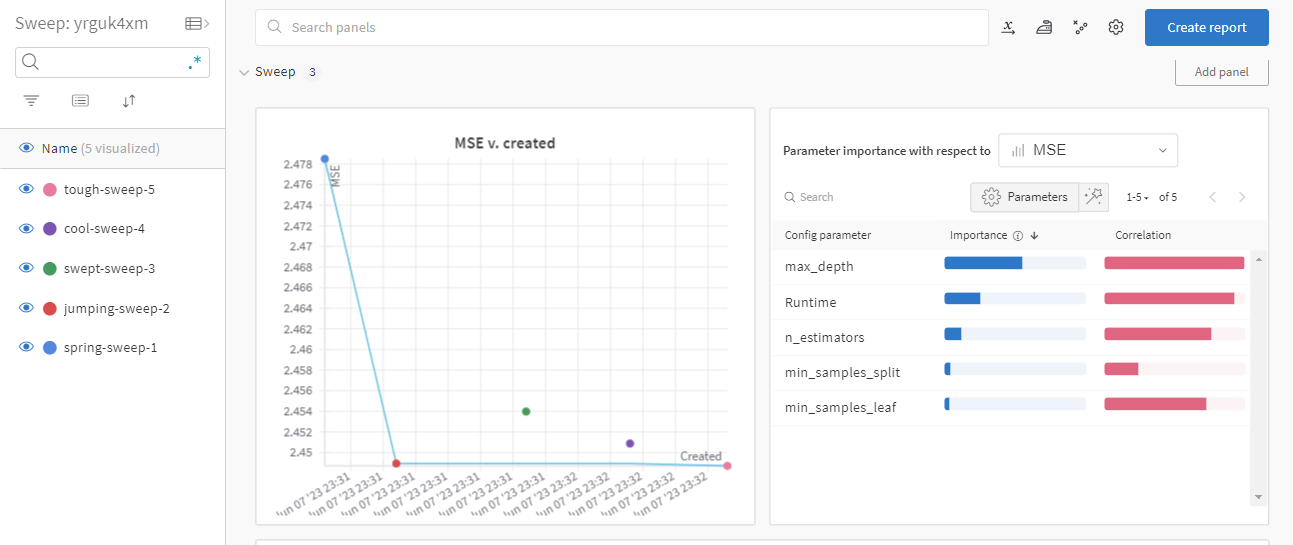

# Q5. Link the best model to the model registry

Now that we have obtained the optimal set of hyperparameters and trained the best model, we can assume that we are ready to test some of these models in production. In this exercise, you'll create a model registry and link the best model from the Sweep to the model registry.

First, you will need to create a Registered Model to hold all the candidate models for your particular modeling task. You can refer to [this section](https://docs.wandb.ai/guides/models/walkthrough#1-create-a-new-registered-model) of the official docs to learn how to create a registered model using the Weights & Biases UI.

Once you have created the Registered Model successfully, you can navigate to the best run of your sweep, navigate to the model artifact created by the particular run, and click on the Link to Registry option from the UI. This would link the model artifact to the Registered Model. You can choose to add some suitable aliases for the Registered Model, such as `production`, `best`, etc.

Now that the model artifact is linked to the Registered Model, which of these information do we see on the Registered Model UI?

* Versioning
* Metadata
* Aliases
* Metric (MSE)
* Source run
* All of these
* None of these

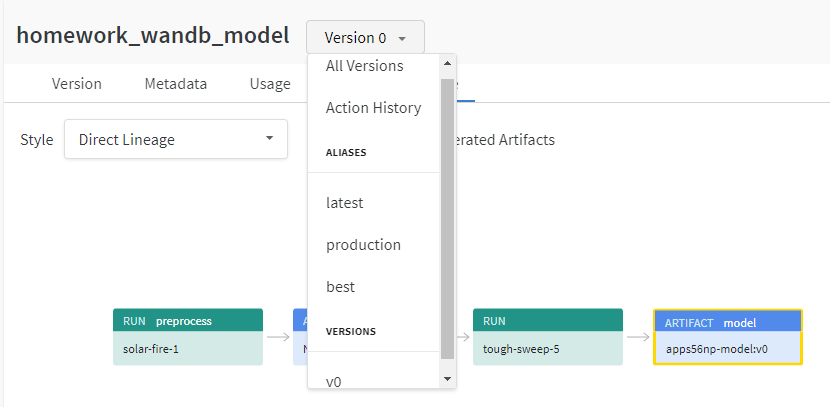